# Adversarial attack на датасете MNIST

In [1]:
import time
import numpy as np
import warnings
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision as tv
import torchvision.models as models
import torch.optim as O
from torch.autograd import Variable

In [2]:
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Функция для просмотра нескольких случайных изображений из датасета
def peep(data, H, W):
    fig = plt.figure(figsize=(16,3*H))
    for i in range(H*W):
        fig.add_subplot(H, W, i+1)
        plt.imshow(data[int(np.random.choice(len(data), 1))][0].permute(1,2,0), cmap='Greys')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [4]:
# Универсальное обучение модели с выводом метрик
class NetPipeline:
    def __init__(self, train_data, test_data, model, num_epochs, batch_size,  
                 first_opt=O.Adam, lr1=3e-4, criterion=nn.CrossEntropyLoss(), second_opt=False, lr2=False):
        self.train_data = train_data
        self.test_data = test_data
        self.model = model
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = criterion
        self.first_opt = first_opt
        self.lr1 = lr1
        self.second_opt = second_opt
        self.lr2 = lr2
        self.train_loader = torch.utils.data.DataLoader(dataset=self.train_data, 
                                                        batch_size=self.batch_size, 
                                                        shuffle=False)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.train_data, 
                                                       batch_size=self.batch_size, 
                                                       shuffle=False)
        
        
    def train_steps(self):
        self.model.to(device)
        trainer_1 = self.first_opt((self.model).parameters(), lr=self.lr1)
        if self.second_opt: 
            trainer_2 = self.second_opt(self.model.parameters(), lr=self.lr2)
        for epoch in range(self.num_epochs):
            start = time.time()
            self.first_train = self._training(self.train_loader, trainer=trainer_1)
            self.second_train = self._training(self.train_loader, trainer=trainer_2) if self.second_opt else False 
            self.last_train = self._training(self.test_loader, mode='eval')
            time_spent = time.time() - start
            self._printer(epoch, time_spent)
        self.model.to('cpu')
        torch.cuda.empty_cache()

    
    def _training(self, data, trainer=False, mode='train'):
        self.model.eval() if mode == 'eval' else self.model.train()
        dict = {'loss':0, 'tp':0, 'iters':0, 'len':0}
        for X, y in data:
            X, y = X.to(device), y.to(device)
            if mode == 'train': 
                trainer.zero_grad()
            predictions = self.model(X)
            loss = self.criterion(predictions, y)
            loss.backward()
            if mode == 'train': 
                trainer.step()
            dict = {'loss':(dict['loss']+loss.item()), 
                    'tp':(dict['tp']+(predictions.argmax(dim=1) == y).sum().item()), 
                    'iters':(dict['iters']+1), 
                    'len':(dict['len']+len(X))}
            del X, y, predictions, loss
        return {'loss':(dict['loss']/dict['iters']), 'acc':(dict['tp']/dict['len'])} 
            
    
    def _printer (self, epoch, time_spent):
        name_1 = self.first_opt.__name__
        name_2 = self.second_opt.__name__ if self.second_opt else False
        if not epoch:
            #print(self.model.__class__.__name__)
            print('|{: ^8}|{: ^9}|'.format('Epochs','Time') + \
                  '{: ^17}|{: ^16}|'.format('Train '+name_1+' loss', 'Train '+name_1+' acc') + \
                  ('{: ^17}|{: ^16}|'.format('Train '+str(name_2)+' loss', 
                                             'Train '+str(name_2)+' acc')if self.second_opt else '') + \
                  '{: ^11}|{: ^10}|'.format('Test loss', 'Test acc'))

        print('|{: ^8}|{: ^9.4f}|'.format(epoch, time_spent) + \
              '{: ^17.4f}|{: ^16.4%}|'.format(self.first_train['loss'], self.first_train['acc']) + \
              ('{: ^17.4f}|{: ^16.4%}|'.format(self.second_train['loss'], 
                                               self.second_train['acc'])if self.second_opt else '') + \
              '{: ^11.4f}|{: ^10.4%}|'.format(self.last_train['loss'], self.last_train['acc']))

In [5]:
LeNet = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
                      nn.Sigmoid(),
                      nn.AvgPool2d(kernel_size=2, stride=2),
                      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
                      nn.Sigmoid(),
                      nn.AvgPool2d(kernel_size=2, stride=2),
                      nn.Flatten(),
                      nn.Linear(in_features=5*5*16, out_features=120),
                      nn.Sigmoid(),
                      nn.Linear(in_features=120, out_features=84),
                      nn.Sigmoid(),
                      nn.Linear(in_features=84, out_features=10)
                      )

In [6]:
def predict(image):
    return LeNet(image).data[0].max(0)[1].item()

Выведем по несколько изображений из каждой выборки, а так же список классов:

Train data sample:


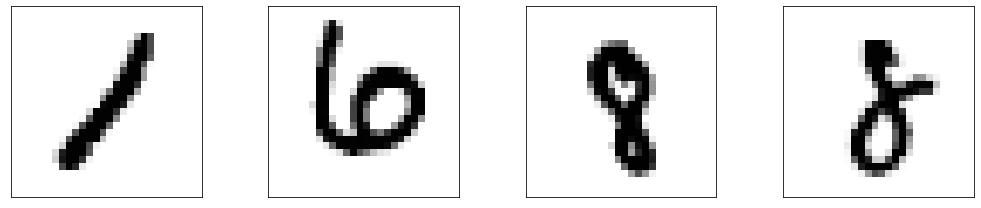

Test data sample:


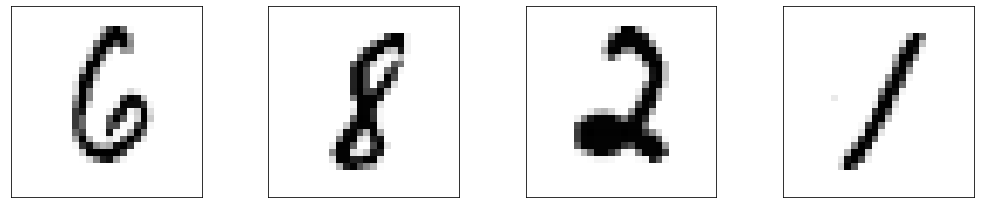

Data classes:
0 - zero
1 - one
2 - two
3 - three
4 - four
5 - five
6 - six
7 - seven
8 - eight
9 - nine


In [7]:
transforms = tv.transforms.ToTensor()
train = tv.datasets.MNIST('.', train=True, transform=transforms, download=True)
test = tv.datasets.MNIST('.', train=False, transform=transforms, download=True)
print('Train data sample:')
peep(train, 1, 4)
print('Test data sample:')
peep(test, 1, 4)
print('Data classes:\n' + '\n'.join(train.classes))

Обучим модель на пяти эпохах, и проверим, как соотносятся её предсказания с реальным изображением:

In [8]:
NetPipeline(train, test, 
            model=LeNet, num_epochs=5, batch_size=30, 
            first_opt=O.Adam, lr1=3e-4).train_steps()

| Epochs |  Time   | Train Adam loss | Train Adam acc | Test loss | Test acc |
|   0    | 45.7590 |     1.7534      |    39.9800%    |  0.7969   | 77.2117% |
|   1    | 48.9620 |     0.5591      |    84.0950%    |  0.4392   | 86.9200% |
|   2    | 46.1345 |     0.3486      |    89.6967%    |  0.3176   | 90.2900% |
|   3    | 41.3818 |     0.2659      |    91.9533%    |  0.2521   | 92.1967% |
|   4    | 49.9155 |     0.2169      |    93.4383%    |  0.2084   | 93.5383% |


Predicted class: 8


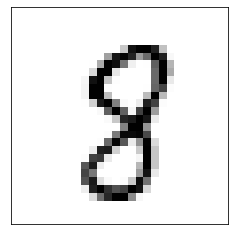

In [9]:
img = test[int(np.random.choice(len(test), 1))][0].unsqueeze(0)
print('Predicted class:', predict(img))
plt.imshow(img.squeeze(), cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()

Теперь перейдём к реализации adversarial attack. Я попробовал два разных способа, которые, впрочем, дали идентичные результаты.  


**Первый вариант**  
Берём случайню картинку и изменяем её так, чтобы она была максимально похожа на второй по вероятности класс. Затем из полученного изображения вычитаем оригинальную картинку, в результате остаются изменения, внесённые моделью. Выводим на экран сначала исходное изображение, затем фильтр (разницу между оригинальным и изменённым изображением), и оригинал с наложенным фильтром. Также, для каждого из этих изображений выводим предсказанный класс.

In [10]:
def inference_1(dataset, cnt, lr):
    print('{: ^26}'.format('Raw image'),
     ' '*13 + '{: ^23}'.format('Filter'),
     ' '*14 + '{: ^23}'.format('New image'))
    for _ in range(cnt):
        img = dataset[int(np.random.choice(len(dataset), 1))][0].unsqueeze(0)
        new_img = torch.tensor(img, requires_grad=True)
        true_label = predict(img)
        for _ in range(100):
            out = LeNet(new_img)
            # Заменяем вероятности правильного класса самым маленьким значением из всего out
            out[0][true_label] = out.data[0].min(0)[0].item()
            # Рассчитываем градиенты для наиболее вероятного класса из оставшихся. Таким образом,
            # мы всегда будем подтягивать изображение ко второму по вероятности классу.
            out[0][out.data[0].max(0)[1].item()].backward()
            ngrad = new_img.grad
            with torch.no_grad():
                new_img += lr * ngrad
            new_img.grad.zero_()

        new_img = new_img.detach().cpu()
        filter = (new_img - img.cpu()).clip(0)
        images = [img, filter, img + filter]
        titles = ['Predict: ' + str(predict(images[0])), 
                  'Predict: ' + str(predict(images[1])), 
                  'Predict: ' + str(predict(images[2]))]
        fig = plt.figure(figsize=(16,3))
        for i in range(3):
            fig.add_subplot(1, 3, i+1)
            plt.imshow(images[i].squeeze(), cmap='Greys')
            plt.title(titles[i])
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

        Raw image                               Filter                               New image       


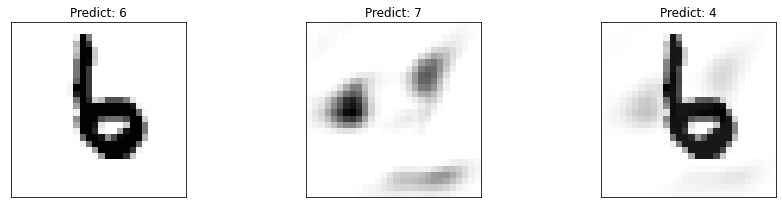

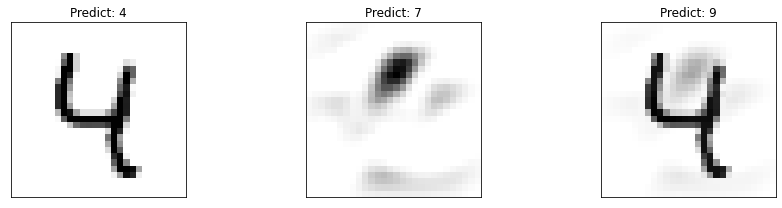

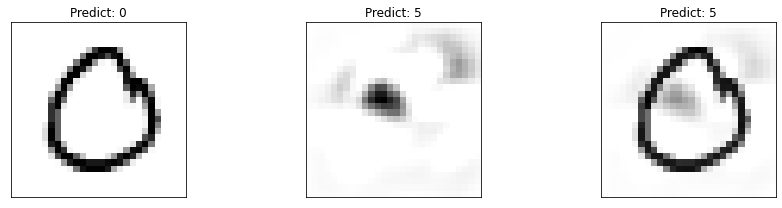

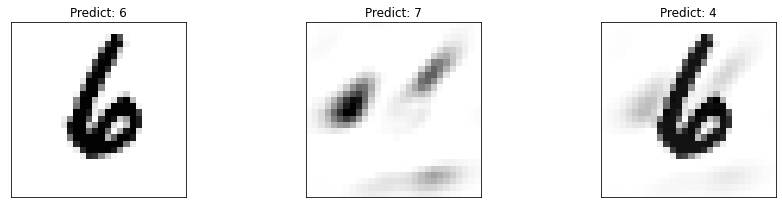

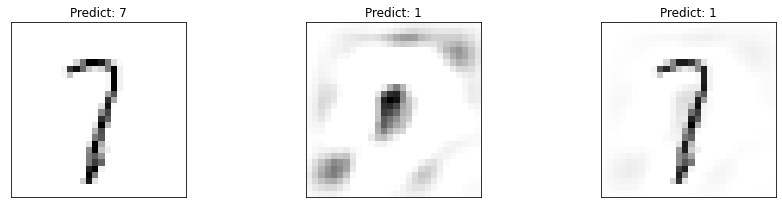

In [11]:
inference_1(test, cnt=5, lr=.05)

**Второй вариант**  
Сразу создаём пустой фильтр, который потом будем изменять. Предсказания модели делаем при наложенном фильтре, затем, как и в прошлый раз, фильтр подгоняем под второй по вероятности класс.

In [12]:
def inference_2(dataset, cnt, lr):
    print('{: ^26}'.format('Raw image'),
     ' '*13 + '{: ^23}'.format('Filter'),
     ' '*14 + '{: ^23}'.format('New image'))
    preprocess = tv.transforms.ToTensor()
    for _ in range(cnt):
        img = dataset[int(np.random.choice(len(dataset), 1))][0].unsqueeze(0)
        filter = preprocess(Image.fromarray(np.zeros([28,28],dtype=np.uint8))).unsqueeze(0)
        filter = torch.tensor(filter, requires_grad=True)
        true_label = predict(img)
        for _ in range(100):
            out = LeNet(img + filter)
            # Заменяем вероятности правильного класса самым маленьким значением из всего out
            out[0][true_label] = out.data[0].min(0)[0].item()
            # Рассчитываем градиенты для наиболее вероятного класса из оставшихся. Таким образом,
            # мы всегда будем подтягивать изображение ко второму по вероятности классу.
            out[0][out.data[0].max(0)[1].item()].backward()
            ngrad = filter.grad
            with torch.no_grad():
                filter += lr * ngrad
            filter.grad.zero_()

        filter = filter.detach().clip(0)
        images = [img, filter, img + filter]
        titles = ['Predict: ' + str(predict(images[0])), 
                  'Predict: ' + str(predict(images[1])), 
                  'Predict: ' + str(predict(images[2]))]
        fig = plt.figure(figsize=(16,3))
        for i in range(3):
            fig.add_subplot(1, 3, i+1)
            plt.imshow(images[i].squeeze(), cmap='Greys')
            plt.title(titles[i])
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

        Raw image                               Filter                               New image       


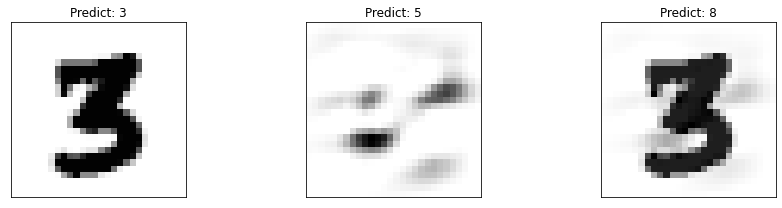

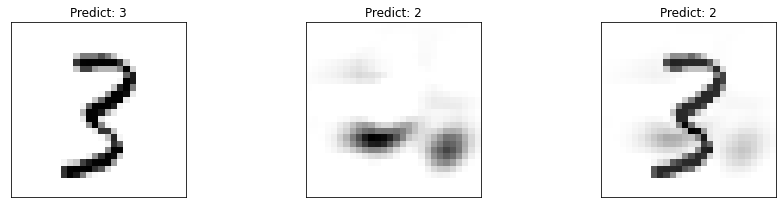

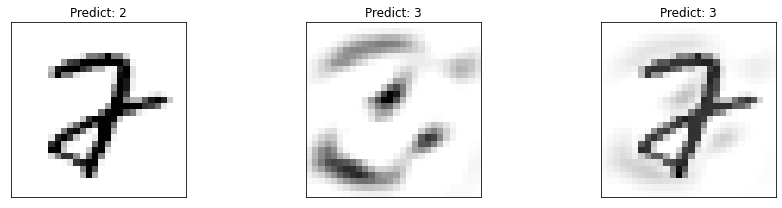

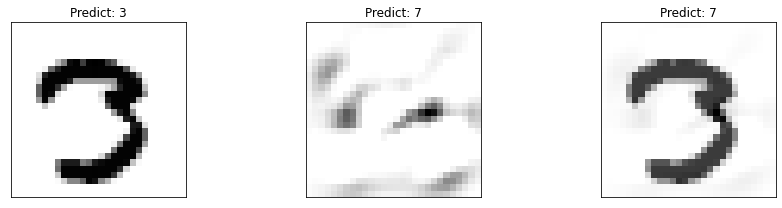

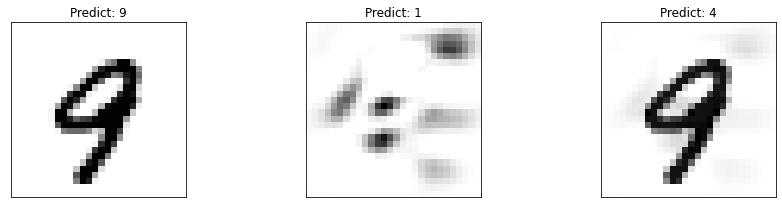

In [13]:
inference_2(test, 5, .05)